In [24]:
import open3d as o3d
import numpy as np
import copy

def draw_registration_result(source, target, transformation):
    """Visualize the alignment of two point clouds."""
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    print("im here")
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

def preprocess_point_cloud(pcd, voxel_size):
    """Downsample and estimate normals for a point cloud."""
    pcd_down = pcd.voxel_down_sample(voxel_size)
    pcd_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 2, max_nn=30))
    print("im here")
    return pcd_down

def pairwise_registration(source, target, voxel_size, initial_transformation):
    """Perform pairwise registration using point-to-point ICP."""
    threshold = voxel_size * 1.5
    source_down = preprocess_point_cloud(source, voxel_size)
    target_down = preprocess_point_cloud(target, voxel_size)
    
    print("im here")
    evaluation = o3d.pipelines.registration.evaluate_registration(source_down, target_down, threshold, initial_transformation)
    print(f"Initial alignment: Fitness {evaluation.fitness:.4f}, Inlier RMSE {evaluation.inlier_rmse:.4f}")
    print("im here")
    print("Initial Transformation Matrix:")
    print(initial_transformation)
    
    reg_p2p = o3d.pipelines.registration.registration_icp(source_down, target_down, threshold, initial_transformation,o3d.pipelines.registration.TransformationEstimationPointToPoint())
    
    print("ICP Transformation Matrix:")
    print(reg_p2p.transformation)
    
    print(f"ICP alignment: Fitness {reg_p2p.fitness:.4f}, Inlier RMSE {reg_p2p.inlier_rmse:.4f}")
    return reg_p2p.transformation

pcd1 = o3d.io.read_point_cloud("selected_pcds/pointcloud_0000.pcd")
pcd2 = o3d.io.read_point_cloud("selected_pcds/pointcloud_0004.pcd")

voxel_size = 0.05
initial_transformation = np.eye(4)

transformation = pairwise_registration(pcd1, pcd2, voxel_size, initial_transformation)

draw_registration_result(pcd1, pcd2, transformation)


im here
im here
im here
Initial alignment: Fitness 0.9873, Inlier RMSE 0.0198
im here
Initial Transformation Matrix:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
ICP Transformation Matrix:
[[ 9.99999988e-01 -1.48888745e-04  3.74253766e-05 -4.38870580e-03]
 [ 1.48888602e-04  9.99999989e-01  3.81676438e-06  2.58107696e-05]
 [-3.74259444e-05 -3.81119213e-06  9.99999999e-01  1.09288603e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
ICP alignment: Fitness 0.9871, Inlier RMSE 0.0194
im here


In [1]:
import open3d as o3d
import numpy as np
import copy
from scipy.stats import ortho_group
from open3d.pipelines import registration  

def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    print("Im here")
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

def preprocess_point_cloud(pcd, voxel_size):
    pcd_down = pcd.voxel_down_sample(voxel_size)
    print("Im here")

    pcd_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 2, max_nn=30)  )
    return pcd_down

def pairwise_registration(source, target, voxel_size, initial_transformation, threshold):
    source_down = preprocess_point_cloud(source, voxel_size)
    target_down = preprocess_point_cloud(target, voxel_size)
    print("Im here")

    evaluation = registration.evaluate_registration(source_down, target_down, threshold, initial_transformation)
    print(f"Initial alignment: Fitness {evaluation.fitness:.4f}, Inlier RMSE {evaluation.inlier_rmse:.4f}")
    reg_p2p = registration.registration_icp( source_down, target_down, threshold, initial_transformation, registration.TransformationEstimationPointToPoint())
    print("Im here")

    print(f"ICP alignment: Fitness {reg_p2p.fitness:.4f}, Inlier RMSE {reg_p2p.inlier_rmse:.4f}")
    return reg_p2p.transformation, reg_p2p.fitness, reg_p2p.inlier_rmse

def ransac_initial_guess(source, target, voxel_size):
    """Compute RANSAC-based initial transformation."""
    distance_threshold = voxel_size * 1.5
    source_down = preprocess_point_cloud(source, voxel_size)
    target_down = preprocess_point_cloud(target, voxel_size)
    print("Im here")

    source_fpfh = registration.compute_fpfh_feature(source_down, o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 5, max_nn=100))
    target_fpfh = registration.compute_fpfh_feature( target_down, o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 5, max_nn=100) )
    result_ransac = registration.registration_ransac_based_on_feature_matching(source_down, target_down, source_fpfh, target_fpfh, mutual_filter=True,  max_correspondence_distance=distance_threshold,estimation_method=registration.TransformationEstimationPointToPoint(False), ransac_n=4, checkers=[  registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),  registration.CorrespondenceCheckerBasedOnDistance(distance_threshold) ], criteria=registration.RANSACConvergenceCriteria(100000, 0.999))
    return result_ransac.transformation

pcd1 = o3d.io.read_point_cloud("selected_pcds/pointcloud_0000.pcd")
pcd2 = o3d.io.read_point_cloud("selected_pcds/pointcloud_0004.pcd")

voxel_sizes = [0.05, 0.1, 0.2]
threshold_values = [0.1, 0.2, 0.3]

experiment_results = []

voxel_size_index = 0
while voxel_size_index < len(voxel_sizes):
    voxel_size = voxel_sizes[voxel_size_index]
    threshold_index = 0
    while threshold_index < len(threshold_values):
        threshold = threshold_values[threshold_index]
        print(f"\nExperiment with Voxel Size: {voxel_size}, Threshold: {threshold}")
        
        initial_transformation = np.eye(4)
        transformation, fitness, rmse = pairwise_registration(pcd1, pcd2, voxel_size, initial_transformation, threshold)
        experiment_results.append(['Identity Matrix', voxel_size, threshold, fitness, rmse, transformation])
        
        random_rotation = ortho_group.rvs(dim=3)
        initial_transformation = np.eye(4)
        initial_transformation[:3, :3] = random_rotation
        transformation, fitness, rmse = pairwise_registration(pcd1, pcd2, voxel_size, initial_transformation, threshold )
        experiment_results.append(['Random Orthogonal Matrix', voxel_size, threshold, fitness, rmse, transformation])
        
        initial_transformation = ransac_initial_guess(pcd1, pcd2, voxel_size)
        transformation, fitness, rmse = pairwise_registration(pcd1, pcd2, voxel_size, initial_transformation, threshold )
        experiment_results.append(['RANSAC Initial Guess', voxel_size, threshold, fitness, rmse, transformation])
        
        threshold_index += 1
    voxel_size_index += 1


import pandas as pd
df = pd.DataFrame(experiment_results, columns=[ 'Initial Guess', 'Voxel Size', 'Threshold', 'Fitness', 'RMSE', 'Transformation Matrix'])

print("\nExperiment Results:")
print(df)

best_fit = df.loc[df['Fitness'].idxmax()]
best_rmse = df.loc[df['RMSE'].idxmin()]
print("\nBest Parameters based on Fitness:")
print(best_fit)
print("\nBest Parameters based on RMSE:")
print(best_rmse)

best_transformation = best_fit['Transformation Matrix']
pcd1_transformed = copy.deepcopy(pcd1)
pcd1_transformed.transform(best_transformation)

draw_registration_result(pcd1_transformed, pcd2, np.eye(4))


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.

Experiment with Voxel Size: 0.05, Threshold: 0.1
Im here
Im here
Im here
Initial alignment: Fitness 0.9939, Inlier RMSE 0.0209
Im here
ICP alignment: Fitness 0.9937, Inlier RMSE 0.0206
Im here
Im here
Im here
Initial alignment: Fitness 0.1028, Inlier RMSE 0.0673
Im here
ICP alignment: Fitness 0.1405, Inlier RMSE 0.0538
Im here
Im here
Im here
Im here
Im here
Im here
Initial alignment: Fitness 0.9946, Inlier RMSE 0.0225
Im here
ICP alignment: Fitness 0.9937, Inlier RMSE 0.0206

Experiment with Voxel Size: 0.05, Threshold: 0.2
Im here
Im here
Im here
Initial alignment: Fitness 0.9991, Inlier RMSE 0.0227
Im here
ICP alignment: Fitness 0.9991, Inlier RMSE 0.0225
Im here
Im here
Im here
Initial alignment: Fitness 0.0909, Inlier RMSE 0.1239
Im here
ICP alignment: Fitness 0.1609, Inlier RMSE 0.1205
Im here
Im here
Im here
Im 

In [2]:
best_fit['Transformation Matrix']

array([[ 9.99999984e-01, -1.71576610e-04,  4.68396288e-05,
        -4.28356978e-03],
       [ 1.71576591e-04,  9.99999985e-01,  4.11195508e-07,
        -4.36617041e-04],
       [-4.68396986e-05, -4.03158918e-07,  9.99999999e-01,
         3.00209219e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here
Im here


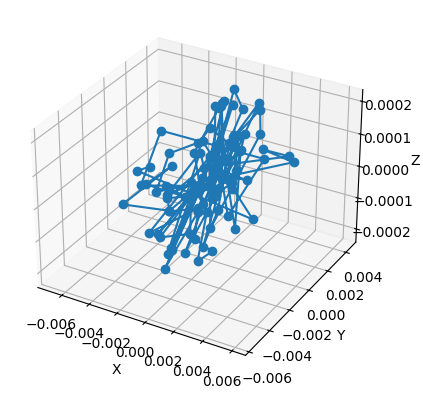

Im here
Im here


In [ ]:
import open3d as o3d
import numpy as np
import os
import copy
import matplotlib.pyplot as plt
import pandas as pd

def preprocess_point_cloud(pcd, voxel_size):
    """Downsample and estimate normals for a point cloud."""
    pcd_down = pcd.voxel_down_sample(voxel_size)
    pcd_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 2, max_nn=30) )
    print("Im here")

    return pcd_down

def pairwise_registration(source, target, voxel_size, initial_transformation, threshold):
    source_down = preprocess_point_cloud(source, voxel_size)
    target_down = preprocess_point_cloud(target, voxel_size)
    print("Im here")

    reg_p2p = o3d.pipelines.registration.registration_icp(source_down, target_down, threshold, initial_transformation,o3d.pipelines.registration.TransformationEstimationPointToPoint()  )
    return reg_p2p.transformation

def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    print("Im here")

    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

print("Im here")
pcd_files = sorted([f for f in os.listdir('selected_pcds') if f.endswith('.pcd')])
pcds = [o3d.io.read_point_cloud(os.path.join('selected_pcds', f)) for f in pcd_files]

voxel_size = 0.05  
threshold = 0.1    

transformations = [np.eye(4)]
trajectory = []

print("Im here")
for i in range(1, len(pcds)):
    source = pcds[i-1]
    target = pcds[i]
    initial_transformation = transformations[-1]
    transformation = pairwise_registration(  source, target, voxel_size, initial_transformation, threshold )
    transformations.append(transformation)
    trajectory.append(transformation[:3, 3])

trajectory = np.array(trajectory)

print("plotting")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

print("Im here")
trajectory_df = pd.DataFrame(trajectory, columns=['X', 'Y', 'Z'])
trajectory_df.to_csv('turtlebot_trajectory.csv', index=False)

print("Im here")
global_pcd = o3d.geometry.PointCloud()
for i, pcd in enumerate(pcds):
    pcd.transform(transformations[i])
    global_pcd += pcd

o3d.visualization.draw_geometries([global_pcd])
